<a href="https://colab.research.google.com/github/botkin92/ML_in_business/blob/lesson_2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

Ниже выкопировка из методички, до ДЗ.

In [ ]:
import pandas as pd

Наши новости

In [ ]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [ ]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [ ]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [ ]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\obotk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [ ]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [ ]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [ ]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\obotk\AppData\Local\Temp/ipykernel_5068/3066725202.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 43.3 s


In [ ]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 6min 24s


А теперь в 3 строчки обучим нашу модель

In [ ]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [ ]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [ ]:
common_dictionary[10]

'ватутин'

In [ ]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 3),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 3),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

Все просто - это словарь наших слов

Запускаем обучение

In [ ]:
from gensim.models import LdaModel

In [ ]:
LdaModel?

In [ ]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 57.8 s


In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [ ]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(1, 0.37577832),
 (5, 0.06609463),
 (6, 0.2360145),
 (21, 0.2360405),
 (22, 0.0682921)]

In [ ]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: индия сближение малое синтез км порог корзина
topic_1: это напомнить год свой время который британский
topic_2: ребёнок nn инвестиция который квартира центр человек
topic_3: израиль сектор вследствие депутат майкл надзор музыка
topic_4: компания газ млрд агентство экипаж турция вода
topic_5: это который год мочь россия свой российский
topic_6: достигать лёд устойчивый величина золото игра команда
topic_7: сша снижение американский который риск население опубликовать
topic_8: журнал метод космос расчёт северный запуск южный
topic_9: агентство канал свидетель акционер бесплатный медик дверь
topic_10: год банк млрд путин рубль президент который
topic_11: рак рейтинг место определение стать лауреат озеро
topic_12: россия который страна год также статья nn
topic_13: фонд планета проект знаменитый реформа мероприятие год
topic_14: исследование год обнаружить который человек это мозг
topic_15: год nn район город стать фестиваль первый
topic_16: поверхность остров китай китайский филь

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [ ]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.022152,0.000000,0.0,0.000000,0.072262,0.00000,0.0,...,0.000000,0.0,0.014179,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000
1,4896,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.230761,0.00000,0.0,...,0.000000,0.0,0.746231,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000
2,4897,0.0,0.375866,0.000000,0.000000,0.0,0.066120,0.236018,0.00000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.235926,0.06829,0.0,0.000000
3,4898,0.0,0.000000,0.000000,0.013152,0.0,0.259748,0.163699,0.08877,0.0,...,0.028035,0.0,0.000000,0.0,0.0,0.0,0.270714,0.00000,0.0,0.145654
4,4899,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,...,0.973308,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [ ]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [ ]:
doc_dict[293622]

array([0.        , 0.        , 0.16712803, 0.0416281 , 0.        ,
       0.        , 0.        , 0.23119484, 0.        , 0.04297817,
       0.1220513 , 0.        , 0.13798097, 0.03263251, 0.        ,
       0.03419262, 0.05817057, 0.        , 0.        , 0.        ,
       0.0438525 , 0.        , 0.        , 0.        , 0.07968909])

In [ ]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding(user_articles_list)

array([0.        , 0.00550409, 0.        , 0.        , 0.00182899,
       0.34684123, 0.        , 0.0406578 , 0.00502782, 0.00378864,
       0.16430882, 0.        , 0.17554788, 0.        , 0.06881584,
       0.        , 0.        , 0.05369493, 0.00352898, 0.01007951,
       0.00489278, 0.00596475, 0.00350862, 0.        , 0.09327629])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [ ]:
#users['articles'].iloc[33]

In [ ]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [ ]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.161209,0.008838,0.000000,0.099918,0.0,0.038532,0.003490,...,0.139574,0.024012,0.029994,0.0,0.00000,0.022283,0.041363,0.000000,0.0,0.139085
1,u108690,0.003673,0.016264,0.014910,0.009551,0.002002,0.326490,0.0,0.063949,0.000000,...,0.038655,0.003505,0.091742,0.0,0.00000,0.003337,0.059562,0.014060,0.0,0.085758
2,u108339,0.000000,0.016163,0.033867,0.000000,0.015177,0.154371,0.0,0.027748,0.028004,...,0.097205,0.002820,0.189677,0.0,0.00829,0.007010,0.043417,0.003816,0.0,0.025947


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.161209,0.008838,0.000000,0.099918,0.0,0.038532,0.003490,...,0.024012,0.029994,0.0,0.00000,0.022283,0.041363,0.000000,0.0,0.139085,0
1,u108690,0.003673,0.016264,0.014910,0.009551,0.002002,0.326490,0.0,0.063949,0.000000,...,0.003505,0.091742,0.0,0.00000,0.003337,0.059562,0.014060,0.0,0.085758,1
2,u108339,0.000000,0.016163,0.033867,0.000000,0.015177,0.154371,0.0,0.027748,0.028004,...,0.002820,0.189677,0.0,0.00829,0.007010,0.043417,0.003816,0.0,0.025947,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.21689879, 0.06509965, 0.24352056, 0.16996683, 0.1592335 ,
       0.15946905, 0.28882114, 0.01736548, 0.04139543, 0.21619638])

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [ ]:
import itertools

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.184779, F-Score=0.495, Precision=0.363, Recall=0.776


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1422  333]
 [  56  189]]


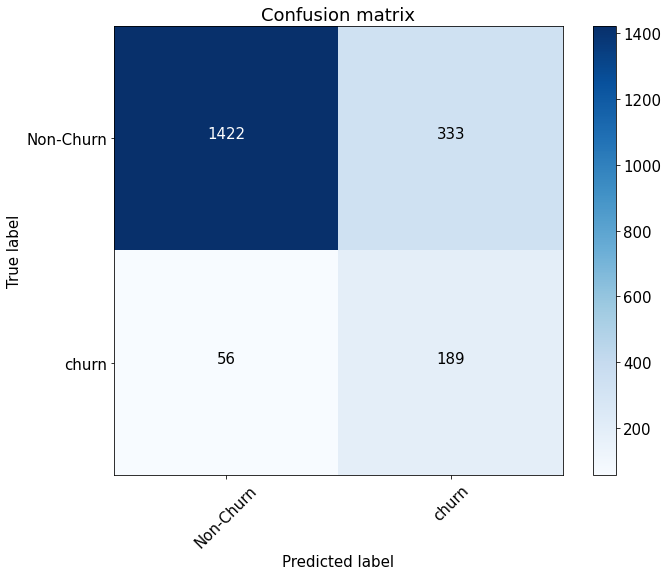

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8798139426710856

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [ ]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3505972 , 0.        , 0.        , 0.        , 0.        ,
       0.07297969, 0.        , 0.16024218, 0.        , 0.01605211,
       0.        , 0.        , 0.04196701, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03276134])

In [ ]:
user_embeddings_1 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_1.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_1['uid'] = users['uid'].values
user_embeddings_1 = user_embeddings_1[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.143576,0.0,0.0,0.039100,0.0,0.000000,0.000000,...,0.091834,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.052799
1,u108690,0.0,0.000000,0.000000,0.0,0.0,0.271389,0.0,0.052716,0.000000,...,0.034400,0.0,0.081956,0.0,0.0,0.0,0.049157,0.01073,0.0,0.042152
2,u108339,0.0,0.005566,0.013147,0.0,0.0,0.129972,0.0,0.016482,0.010326,...,0.054853,0.0,0.191041,0.0,0.0,0.0,0.021547,0.00000,0.0,0.023946


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X_1 = pd.merge(user_embeddings_1, target, 'left')
X_1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.143576,0.0,0.0,0.039100,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.052799,0
1,u108690,0.0,0.000000,0.000000,0.0,0.0,0.271389,0.0,0.052716,0.000000,...,0.0,0.081956,0.0,0.0,0.0,0.049157,0.01073,0.0,0.042152,1
2,u108339,0.0,0.005566,0.013147,0.0,0.0,0.129972,0.0,0.016482,0.010326,...,0.0,0.191041,0.0,0.0,0.0,0.021547,0.00000,0.0,0.023946,1


In [ ]:
#разделим данные на train/test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_1['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train1, y_train1)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds_1 = logreg.predict_proba(X_test1)[:, 1]
preds_1[:10]

array([0.20410749, 0.01338165, 0.32063971, 0.15422974, 0.1034738 ,
       0.16602869, 0.15106697, 0.05221692, 0.11757071, 0.12538869])

In [ ]:
precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test1, preds_1)
fscore_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1)
# locate the index of the largest f score
ix_1 = np.argmax(fscore_1)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_1], 
                                                                        fscore[ix_1],
                                                                        precision[ix_1],
                                                                        recall[ix_1]))

Best Threshold=0.174177, F-Score=0.483, Precision=0.341, Recall=0.833


Confusion matrix, without normalization
[[1471  284]
 [  22  223]]


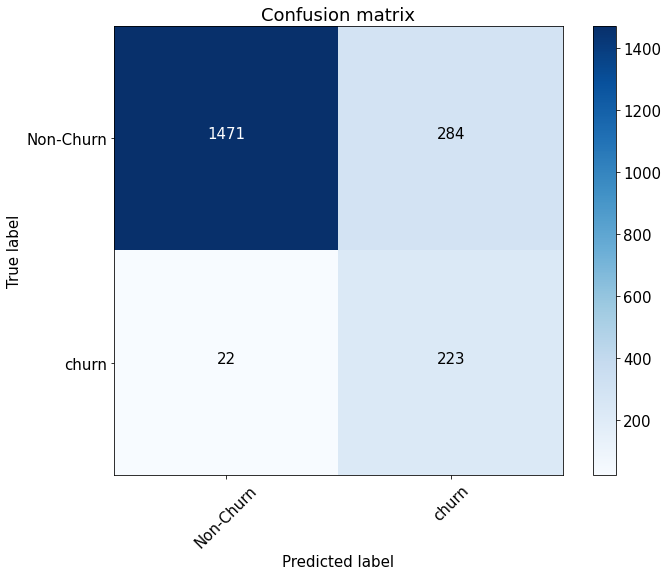

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_1 = confusion_matrix(y_test1, preds_1>thresholds[ix_1])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_1, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc1 = roc_auc_score(y_test1, preds_1)
roc_auc1

0.9504599104599104

Повторим те же действия, но в функции get_user_embedding будем считать максимум

In [ ]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [ ]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.03302453, 0.        , 0.        , 0.01097391,
       0.71542895, 0.        , 0.14907683, 0.01602159, 0.02273186,
       0.69007397, 0.        , 0.36686152, 0.        , 0.32393557,
       0.        , 0.        , 0.12574597, 0.02117389, 0.06047708,
       0.02935668, 0.03578848, 0.02105174, 0.        , 0.29347724])

In [ ]:
user_embeddings_2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_2['uid'] = users['uid'].values
user_embeddings_2 = user_embeddings_2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.00000,0.000000,0.350247,0.041628,0.000000,0.376543,0.0,0.231195,0.020940,...,0.440397,0.085904,0.179962,0.0,0.000000,0.089843,0.171745,0.000000,0.0,0.480612
1,u108690,0.02204,0.054146,0.089459,0.041014,0.012012,0.542185,0.0,0.164632,0.000000,...,0.110036,0.021030,0.169461,0.0,0.000000,0.020024,0.166882,0.044879,0.0,0.229469
2,u108339,0.00000,0.059570,0.111270,0.000000,0.056184,0.354104,0.0,0.086369,0.123606,...,0.351646,0.016918,0.286982,0.0,0.049739,0.024759,0.153129,0.012311,0.0,0.054569


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [ ]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [ ]:
X_2 = pd.merge(user_embeddings_2, target, 'left')
X_2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.00000,0.000000,0.350247,0.041628,0.000000,0.376543,0.0,0.231195,0.020940,...,0.085904,0.179962,0.0,0.000000,0.089843,0.171745,0.000000,0.0,0.480612,0
1,u108690,0.02204,0.054146,0.089459,0.041014,0.012012,0.542185,0.0,0.164632,0.000000,...,0.021030,0.169461,0.0,0.000000,0.020024,0.166882,0.044879,0.0,0.229469,1
2,u108339,0.00000,0.059570,0.111270,0.000000,0.056184,0.354104,0.0,0.086369,0.123606,...,0.016918,0.286982,0.0,0.049739,0.024759,0.153129,0.012311,0.0,0.054569,1


In [ ]:
#разделим данные на train/test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_2['churn'], random_state=0)

In [ ]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train2, y_train2)

LogisticRegression()

In [ ]:
#наши прогнозы для тестовой выборки
preds_2 = logreg.predict_proba(X_test2)[:, 1]
preds_2[:10]

array([0.20788302, 0.00231986, 0.59063633, 0.11608044, 0.06290399,
       0.2560314 , 0.03391669, 0.00544806, 0.02099065, 0.01743386])

In [ ]:
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test2, preds_2)
fscore_2 = (2 * precision_2 * recall_2) / (precision_2 + recall_2)
# locate the index of the largest f score
ix_2 = np.argmax(fscore_2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_2], 
                                                                        fscore[ix_2],
                                                                        precision[ix_2],
                                                                        recall[ix_2]))

Best Threshold=0.176044, F-Score=0.487, Precision=0.345, Recall=0.829


Confusion matrix, without normalization
[[1484  271]
 [  16  229]]


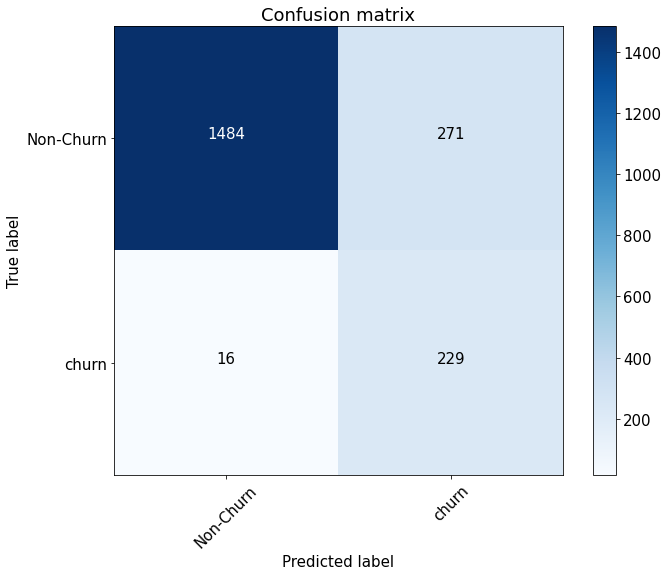

In [ ]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_2 = confusion_matrix(y_test2, preds_2>thresholds[ix_2])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_2, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
roc_auc2 = roc_auc_score(y_test2, preds_2)
roc_auc2

0.9582394325251468

In [ ]:
compare_metrics = pd.DataFrame({'algoritm': ['embedding_mean', 'embedding_median', 'embedding_max'], 'roc_auc_score': [roc_auc, roc_auc1, roc_auc2], 'precision': [precision[ix], precision_1[ix_1], precision_2[ix_2]], 'recall': [recall[ix], recall_1[ix_1], recall_2[ix_2]], 'f_score': [fscore[ix], fscore_1[ix_1], fscore_2[ix_2]]})
compare_metrics

,algoritm,roc_auc_score,precision,recall,f_score
0,embedding_mean,0.879814,0.363289,0.775510,0.494792
1,embedding_median,0.950460,0.657143,0.751020,0.700952
2,embedding_max,0.958239,0.655629,0.808163,0.723949
